In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import pandas as pd
import pandahouse
from urllib.parse import urlencode
import os
import requests

sns.set()
dir_path = '~/t4alekseevk/'

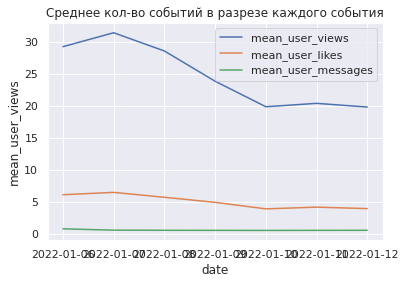

In [ ]:
def report_metriki_full():
    chat_id = -1001646110707
    token=''
    connection = {
            'host': 'https://clickhouse.lab.karpov.courses',
            'password': 'dpo_python_2020',
            'user': 'student',
            'database': 'simulator_20211220'
            }

    q1 = '''
    SELECT 
        toStartOfDay(time) AS date,
        count(DISTINCT user_id) as dau,
        COUNTIf(DISTINCT user_id, category='new') AS new_users,
        count(action) as fuul_actions,
        -- countIf(action='like') AS likes,
        -- countIf(action='view') AS views,
        -- countIf(action='mess') AS messsges,
        floor(count(action) / count(DISTINCT user_id), 2) AS mean_user_actions,
        floor(countIf(action='view')/ count(DISTINCT user_id), 2) AS mean_user_views,
        floor(countIf(action='like')/ count(DISTINCT user_id), 2) AS mean_user_likes,
        floor(countIf(action='mess')/ count(DISTINCT user_id), 2) AS mean_user_messages

    FROM 
        (SELECT 
          user_id,
          time,
          action,
          (time - date_reg) AS distance,
          CASE 
            WHEN distance = 0 THEN 'new'
            ELSE 'old'
            END AS category
        FROM 
            (SELECT
              user_id,
              time,
              action
            FROM simulator.feed_actions 

            UNION ALL 
            SELECT 
              user_id,
              time,
              CAST('mess' AS String) AS action
            FROM 
              simulator.message_actions) AS A
        LEFT JOIN    
        (SELECT 
          user_id,
          MIN(time) AS date_reg
        FROM
          (SELECT
              user_id,
              time,
              action
            FROM simulator.feed_actions 

            UNION ALL 
            SELECT 
              user_id,
              time,
              CAST('mess' AS String) AS action
            FROM 
              simulator.message_actions)
        GROUP BY 
          user_id) AS B
        ON A.user_id = B.user_id )
    GROUP BY 
    date
    HAVING date = yesterday()
    '''
    data = pandahouse.read_clickhouse(q1, connection=connection)
    
    #сообщение

    message = '''
    Отчет по ключевым показателям по ленте и сообщениям {}:
    dau: {}
    users: {}
    events: {}
    Среднее число событий на 1-го пользователя: {}
    Среднее число просмотров на 1-го пользователя: {}
    Среднее число лайков на 1-го пользователя: {}
    Среднее число сообщений на 1-го пользователя: {}
    '''.format(data['date'][0],
               data['dau'][0],
               data['new_users'][0],
               data['fuul_actions'][0],
               data['mean_user_actions'][0],
               data['mean_user_views'][0],
               data['mean_user_likes'][0],
               data['mean_user_messages'][0])
    params = {'chat_id': chat_id, 'text': message}
    base_url = f'https://api.telegram.org/bot{token}/'
    url = base_url + 'sendMessage?' + urlencode(params)
    resp = requests.get(url)

    #Графики.
    q2 = '''
    SELECT 
        toStartOfDay(time) AS date,
        count(DISTINCT user_id) as dau,
        COUNTIf(DISTINCT user_id, category='new') AS new_users,
        count(action) as full_actions,
        -- countIf(action='like') AS likes,
        -- countIf(action='view') AS views,
        -- countIf(action='mess') AS messsges,
        floor(count(action) / count(DISTINCT user_id), 2) AS mean_user_events,
        floor(countIf(action='view')/ count(DISTINCT user_id), 2) AS mean_user_views,
        floor(countIf(action='like')/ count(DISTINCT user_id), 2) AS mean_user_likes,
        floor(countIf(action='mess')/ count(DISTINCT user_id), 2) AS mean_user_messages

    FROM 
        (SELECT 
          user_id,
          time,
          action,
          (time - date_reg) AS distance,
          CASE 
            WHEN distance = 0 THEN 'new'
            ELSE 'old'
            END AS category
        FROM 
            (SELECT
              user_id,
              time,
              action
            FROM simulator_20211220.feed_actions 

            UNION ALL 
            SELECT 
              user_id,
              time,
              CAST('mess' AS String) AS action
            FROM 
              simulator_20211220.message_actions) AS A
        LEFT JOIN    
        (SELECT 
          user_id,
          MIN(time) AS date_reg
        FROM
          (SELECT
              user_id,
              time,
              action
            FROM simulator_20211220.feed_actions 

            UNION ALL 
            SELECT 
              user_id,
              time,
              CAST('mess' AS String) AS action
            FROM 
              simulator_20211220.message_actions)
        GROUP BY 
          user_id) AS B
        ON A.user_id = B.user_id )
    GROUP BY 
    date
    HAVING date >= (yesterday()-6) AND date < today()
    '''
    yesterday_data = pandahouse.read_clickhouse(q2, connection=connection)


    #график dau
    sns.lineplot(data=yesterday_data, x='date', y='dau')
    plt.title('Кол-во уникальных пользователей по дням')
    plt_dau = io.BytesIO()
    plt.savefig(plt_dau)
    plt_dau.name = 'plt_dau.png'
    plt_dau.seek(0)
    plt.close()
    url = base_url + 'sendDocument?' + urlencode(params)
    files = {'document': plt_dau}   
    resp = requests.get(url, files=files)

    #график users
    sns.lineplot(data=yesterday_data, x='date', y='new_users')
    plt.title('Кол-во новых пользователей')
    plt_new_users = io.BytesIO()
    plt.savefig(plt_new_users)
    plt_new_users.name = 'plt_new_users.png'
    plt_new_users.seek(0)
    plt.close()
    url = base_url + 'sendDocument?' + urlencode(params)
    files = {'document': plt_new_users}   
    resp = requests.get(url, files=files)

    #график events
    sns.lineplot(data=yesterday_data, x='date', y='full_actions')
    plt.title('Кол-во всех событий по дням')
    plt_events = io.BytesIO()
    plt.savefig(plt_events)
    plt_events.name = 'plt_events.png'
    plt_events.seek(0)
    plt.close()
    url = base_url + 'sendDocument?' + urlencode(params)
    files = {'document': plt_events}   
    resp = requests.get(url, files=files)

    #Среднее число событий на 1-го пользователя.
    sns.lineplot(data=yesterday_data, x='date', y='mean_user_events')
    plt.title('Среднее кол-во событий на 1-го пользователя')
    plt_mean_user_events = io.BytesIO()
    plt.savefig(plt_mean_user_events)
    plt_mean_user_events.name = 'plt_mean_user_events.png'
    plt_mean_user_events.seek(0)
    plt.close()
    url = base_url + 'sendDocument?' + urlencode(params)
    files = {'document': plt_mean_user_events}   
    resp = requests.get(url, files=files)

    #Cреднее число каждого события
    sns.lineplot(data=yesterday_data, x='date', y='mean_user_views')
    sns.lineplot(data=yesterday_data, x='date', y='mean_user_likes')
    sns.lineplot(data=yesterday_data, x='date', y='mean_user_messages')
    plt.title('Среднее кол-во событий в разрезе каждого события')
    plt.legend(['mean_user_views', 'mean_user_likes', 'mean_user_messages' ])
    plt_mean_user_event_agg = io.BytesIO()
    plt.savefig(plt_mean_user_event_agg)
    plt_mean_user_event_agg.name = 'plt_mean_user_event_agg.png'
    plt_mean_user_event_agg.seek(0)
    plt.close(0)
    url = base_url + 'sendDocument?' + urlencode(params)
    files = {'document':  plt_mean_user_event_agg}   
    resp = requests.get(url, files=files)
    return
    


try:
    report_metriki_full()

except Exception as e:
    print(e)